# Analyzing Open Source Baseball Data

This notebook answers baseball questions that a fan might be interested in. The questions are answered by using Pandas and MLB data from Lahman, Retrosheet and FanGraphs.

This notebook will show how the answer is arrived at, but it will not teach Python, Pandas, Numpy, Matplotlib, and Seaborn per se.

## Setup
[Preliminaries](#Preliminaries)  
[Imports and Setup](#Imports-and-Setup)  
[Load Data](#Load-the-Data)  

## Baseball Analysis/Questions
[Are Baseball Games Getting Longer?](#Are-Baseball-Games-Getting-Longer-?)  
[Are Games Longer due to Using More Pitchers?](#Are-Games-Longer-Due-to-Using-More-Pitchers?)  
[Are Games that Use a DH Higher Scoring?](#Are-Games-that-Use-a-DH-Higher-Scoring?)  

## Preliminaries

This notebook assumes that the Lahman and Retrosheet data sets have been downloaded and wrangled using the scripts in the `../download_scripts` directory of this repo.

For these notebooks, Retrosheet data from 1955 through 2019 inclusive is used.

The `../download_scripts/data_helper.py` function: `from_csv_with_types()` uses pd.read_csv() with dtypes set to the type data read in from: <filename\>_types.csv.  This Pandas to use the optimized data types each time the file is read.

## MLB Data Summary

Most used csv files.

**Lahman**  
* Stats per Player per Year:
  * batting.csv
  * pitching.csv
  * fielding.csv
* Stats per Team per Year:
  * teams.csv -- contains team_id for both Lahman and Retrosheet
* Other
  * people.csv -- contains player_id for both Lahman and Retrosheet
  
**Retrosheet**  
* Stats per Player per Game:
  * batting.csv.gz
  * pitching.csv.gz
  * fielding.csv.gz
* Stats per Team per Game:
  * team_game.csv.gz
* Stats per Game:
  * game.csv.gz 

## Imports and Setup

In [1]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import re
from scipy.stats import linregress

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # increase dpi, will make figures larger and clearer

In [4]:
import sys

# import data_helper.py from download_scripts directory
sys.path.append('../download_scripts')
import data_helper as dh

In [5]:
data_dir = Path('../data')
lahman_data = data_dir.joinpath('lahman/wrangled').resolve()
retrosheet_data = data_dir.joinpath('retrosheet/wrangled').resolve()

In [6]:
pd.set_option("display.max_columns", 50)

## Load the Data

In [7]:
# some columns of interest for this notebook
usecols = ['game_id', 'game_start_dt', 'game_length_minutes', 'game_length_outs', 
           'game_length_innings', 'dh']
game = dh.from_csv_with_types(retrosheet_data / 'game.csv.gz', usecols=usecols)

In [8]:
game.head(3)

,game_id,game_start_dt,game_length_minutes,game_length_innings,game_length_outs,dh
0,BAL195504120,1955-04-12,145,9,54,False
1,BAL195504180,1955-04-18,146,9,54,False
2,BAL195504220,1955-04-22,168,9,54,False


In [9]:
# skip the columns that begin with lineup
usecols = (lambda col: not col.startswith('lineup'))
team_game = dh.from_csv_with_types(retrosheet_data / 'team_game.csv.gz', usecols=usecols)

In [10]:
team_game.head(3)

,game_id,at_home,team_id,start_pit_id,opponent_team_id,r,h,e,lob,finish_pit_id,team_league_id,line_tx,ab,double,triple,hr,rbi,sh,sf,hbp,bb,ibb,so,sb,cs,gidp,xi,pitcher_ct,er,ter,wp,bk,po,a,pb,dp,tp
0,BAL195504120,True,BAL,colej101,BOS,1,5,2,9,ferrd102,A,001000000,29,2,0,0,1,1,1,0,6,0,5,0,1,0,0,3,6,6,0,0,27,12,0,2,0
1,BAL195504180,True,BAL,moorr101,NYA,0,3,1,4,wilsj104,A,000000000,29,0,0,0,0,0,0,0,2,0,6,0,0,0,0,3,4,4,0,0,27,9,0,2,0
2,BAL195504220,True,BAL,wilsj104,WS1,2,8,1,11,johnd102,A,000000200,33,0,1,0,2,0,0,0,7,0,6,0,1,0,0,2,2,2,0,0,27,12,0,1,0


# Are Baseball Games Getting Longer ?

In [11]:
# the analysis is easier if an explicit year column is used
game['year'] = game['game_start_dt'].dt.year

In [12]:
minutes_per_game = \
    game.groupby('year', as_index=False)['game_length_minutes'].aggregate('mean')
minutes_per_game.tail()

,year,game_length_minutes
60,2015,180.804446
61,2016,184.771005
62,2017,188.736626
63,2018,184.953928
64,2019,189.989296


For nicely annotated plots, matplotlib is better.  
For quick data exploration, seaborn is better.

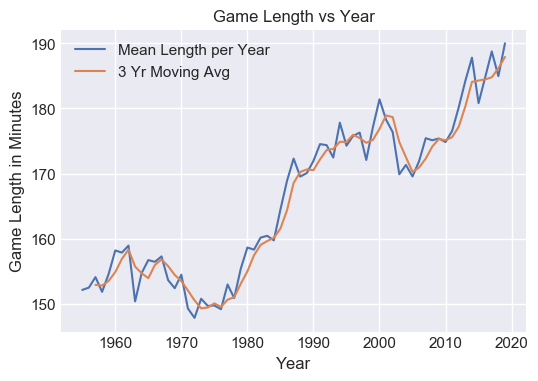

In [13]:
# plot the data and the 3 year moving average
plt.style.use('seaborn-darkgrid')

fig, ax = plt.subplots()
ax.set_title('Game Length vs Year')
ax.set_xlabel('Year')
ax.set_ylabel('Game Length in Minutes')
ax.set_title('Game Length vs Year')
ax.plot('year', 'game_length_minutes', data = minutes_per_game, label='Mean Length per Year')

df_smoothed = minutes_per_game.set_index('year').rolling(3).mean().reset_index()
ax.plot('year', 'game_length_minutes', data=df_smoothed, label='3 Yr Moving Avg')
ax.legend();

## Summary
Baseball games are taking longer to complete.  From the mid 70s through 2019, the game length has increased by about 40 minutes.

The drop in game time from 2000 to about 2005 might be due to a MLB rule change.  For the 2020 season, MLB has changed the rules to speed up games.  It will be interesting to see if the average game length for 2020 is lower than the 3 year moving average.

# Are Games Longer Due to Using More Pitchers?

In [14]:
# the analysis is easier if an explicit year column is used
team_game['year'] = team_game['game_id'].str[3:7].astype('int')

In [15]:
pitcher_ct_mean = team_game.groupby('year', as_index=False)['pitcher_ct'].mean()
pitcher_ct_mean.tail()

,year,pitcher_ct
60,2015,4.109922
61,2016,4.152801
62,2017,4.222016
63,2018,4.361374
64,2019,4.411898


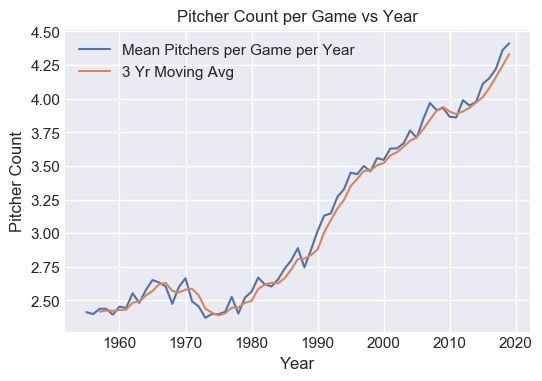

In [16]:
fig, ax = plt.subplots()
ax.set_title('Pitcher Count per Game vs Year')
ax.set_xlabel('Year')
ax.set_ylabel('Pitcher Count')

ax.plot('year', 'pitcher_ct', data=pitcher_ct_mean, label='Mean Pitchers per Game per Year')
df_smoothed2 = pitcher_ct_mean.set_index('year').rolling(3).mean().reset_index()
ax.plot('year', 'pitcher_ct', data=df_smoothed2, label='3 Yr Moving Avg')
ax.legend();

The number of pitchers per game has been steadily increasing since the late 70s.

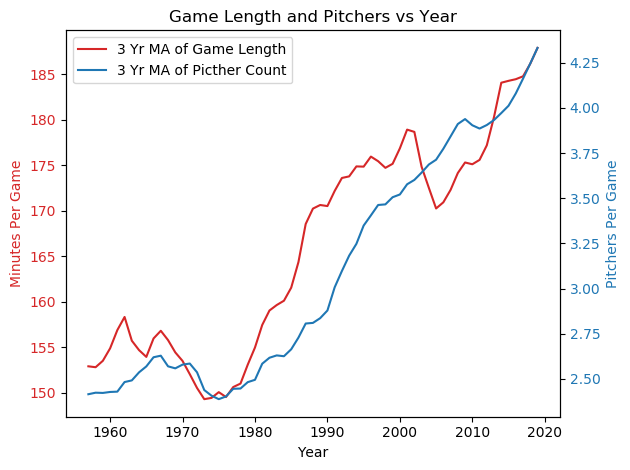

In [17]:
# show game length and pitcher count on same plot

# compute 3 year moving averages
df_smoothed = minutes_per_game.set_index('year').rolling(3).mean().reset_index()
df_smoothed2 = pitcher_ct_mean.set_index('year').rolling(3).mean().reset_index()

x = df_smoothed['year']
y1 = df_smoothed['game_length_minutes']
y2 = df_smoothed2['pitcher_ct']

plt.style.use('default')

fig, ax1 = plt.subplots()
ax1.set_title('Game Length and Pitchers vs Year')
ax1.set_xlabel('Year')

color = 'tab:red'
ax1.set_ylabel('Minutes Per Game', color=color)
lns1 = ax1.plot(x, y1, label='3 Yr MA of Game Length', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Pitchers Per Game', color=color)
lns2 = ax2.plot(x, y2, label='3 Yr MA of Picther Count', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# create the legend
lns = lns1 + lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

fig.tight_layout()

Both have been increasing since the late 70s.

How correlated is the unsmoothed ungrouped data?

In [18]:
# create a df with both pitcher_ct and game_length_minutes
tg_join_g = pd.merge(team_game[['game_id', 'team_id', 'pitcher_ct']], 
                     game[['game_id', 'year', 'game_length_minutes']],
                     left_on='game_id', right_on='game_id', how='inner')
tg_join_g.head(4)

,game_id,team_id,pitcher_ct,year,game_length_minutes
0,BAL195504120,BAL,3,1955,145
1,BAL195504120,BOS,1,1955,145
2,BAL195504180,BAL,3,1955,146
3,BAL195504180,NYA,1,1955,146


In [19]:
tg_join_g['pitcher_ct'].corr(tg_join_g['game_length_minutes']).round(3)

0.618

In [20]:
len(tg_join_g)

264596

In [21]:
# create a set of points (pitcher_ct, mean game_length_minutes)
df_pitcher_time = tg_join_g.groupby(
    'pitcher_ct', as_index=False)['game_length_minutes'].mean()
df_pitcher_time

,pitcher_ct,game_length_minutes
0,1,142.505230
1,2,154.011490
2,3,164.875985
3,4,175.669544
4,5,188.658580
5,6,204.684309
6,7,227.316333
7,8,253.409041
8,9,280.685841
9,10,295.017241


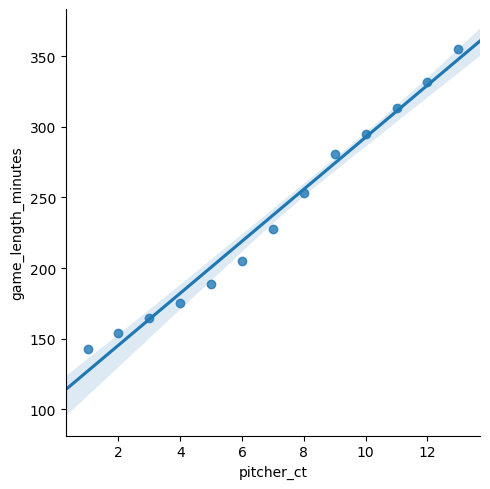

In [22]:
# the relationship looks quite linear
sns.lmplot('pitcher_ct', 'game_length_minutes', data=df_pitcher_time);

In [23]:
# get some additional stats from scipy's linear regression
# note this uses *all* the games, not just the 13 points above
linregress(tg_join_g['pitcher_ct'], tg_join_g['game_length_minutes'])

LinregressResult(slope=12.443809969953797, intercept=128.10686151023674, rvalue=0.6177469195166662, pvalue=0.0, stderr=0.030795238632883658)

From the Linear Regression:  
* r = .618
  * r^2 = .382 => 38% of the variance is explained by the number of pitchers using a linear model
* p-value = 0.0 => statistically significant
* slope  = 12.4  => each additional pitcher adds 12.4 minutes to game length

The above is for the period 1955 through 2019.  Perhaps the relationship is different using just the last 3 years of data?

In [24]:
df_3years = tg_join_g.query('year >= 2017')
linregress(df_3years['pitcher_ct'], df_3years['game_length_minutes'])

LinregressResult(slope=12.308532604873943, intercept=134.5750347238667, rvalue=0.619130565160506, pvalue=0.0, stderr=0.12930164768517483)

The values are nearly the same.

## Summary
Game length and pitchers per game have both increased significantly since the late 70s.

There is a statistically significant linear relationship between the number of pitchers used in a game, and the total time of the game.  Each additional pitcher is associated with a increase in game time of about 12 minutes.

The increase in the number of pitchers explains about 38% of the variance, so there are other factors involved in game length.

The new MLB rules for 2020 to speed up the game are clues as to what MLB thinks is causing the game to take so long.  The new rules are:
* a pitcher must pitch to at least 3 batters or until the end of an inning (unless injured)
* the time between innings is reduced by 5 seconds for most games (and 25 seconds for nationally televised games)
* the number of meetings on the mound is reduced from 6 to 5 per game
* instant reply will be fed more quickly to the dug out so the decision to challenge a call can be made more quickly

# Are Games that Use a DH Higher Scoring?

In [25]:
# find the first year that the dh was used
dh_first = game.loc[game['dh'], 'year'].min()
dh_first

1973

In [26]:
# only consider games from that year on
game_dh = game[game['year'] >= dh_first]

In [27]:
# join between game and team_game to get the scores
df = pd.merge(team_game[['game_id', 'team_id', 'r']], 
              game_dh[['game_id', 'year', 'dh']], 
              left_on='game_id', right_on='game_id', how='inner')
df.head()

,game_id,team_id,r,year,dh
0,ATL197304060,ATL,1,1973,False
1,ATL197304060,HOU,2,1973,False
2,ATL197304081,ATL,3,1973,False
3,ATL197304081,HOU,10,1973,False
4,ATL197304082,ATL,4,1973,False


In [28]:
dh_df = df.groupby('dh')['r'].aggregate(['mean', 'count'])
dh_df

,mean,count
dh,,
False,4.362824,104508
True,4.626851,104658


In [29]:
delta = dh_df.loc[True, 'mean'] - dh_df.loc[False, 'mean']
delta

0.2640273692904769

Given the large number of games, this looks significant.  Run the <a href="https://en.wikipedia.org/wiki/Resampling_(statistics)#Monte_Carlo_testing">Monte Carlo</a> version of the <a href="https://en.wikipedia.org/wiki/Resampling_(statistics)#Permutation_tests">Permutation Test</a> to see how likely this large of a difference is.

In [30]:
dh_r = df.query('dh == True')['r']
no_dh_r = df.query('dh == False')['r']

In [31]:
def perm_test(x, y):
    pooled = np.hstack([x, y])
    np.random.shuffle(pooled)
    x_sample = pooled[:len(x)]
    y_sample = pooled[len(x):]
    return x_sample.mean() - y_sample.mean()

In [32]:
np.random.seed(100)
N = 1000
result_array = np.empty(N)
for i in range(N):
    result_array[i] = perm_test(dh_r, no_dh_r)

In [33]:
result_array.min(), result_array.max()

(-0.03885183947546089, 0.03976518459555578)

In [34]:
(result_array >= delta).sum()

0

There are no random permutations which show anywhere near as large of a run difference as was observed by partitioning games into "DH used" and "DH not used".

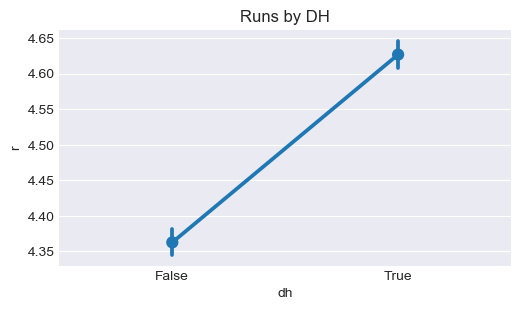

In [35]:
# seaborn catplot: group by values of 'x' and display the mean of 'y'
plt.style.use('seaborn-darkgrid')
sns.catplot(x="dh", y="r", data=df, kind="point", height=3, aspect=1.77)
plt.title('Runs by DH');

## Summary
On average, about 1/4 of a run per team per game more is scored when the Designated Hitter is used. This difference is much greater than could be observed by chance alone.

The DH is better at producing runs than the pitcher.  (It would be interesting to compare the wOBA Sabermetric for pitchers vs the DH.)

That said, the DH may not be responsible the entire 1/4 run difference.  There may be additional factors because the DH is only used in the American League and perhaps there is something else different about hitting in the American League.  Perhaps it's easier to score runs in American league parks.  Perhaps the National League has much better pitchers.  These are not likely to be as significant to run scoring as the use of the DH, but further analysis would be needed to say if the entire 1/4 run per team per game could be attributed to the use of the DH.

As the DH is only used in games that are played in American League parks, it would be more accurate to summarize the above as:
* games played in American League parks have about 1/4 run per team per game more than games played in National League parks